In [54]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [52]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None  # Function to compute the gradient
        self._prev = set(_children)  # Previous nodes in the computation graph
        self._op = _op  # Operation that produced this value
        self.label = label  # Optional label for the value

    def __repr__(self):
        # Print out the value in a readable format
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # Ensure that the other operand is also a Value instance in case integer
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        # Ensure that the other operand is also a Value instance in case integer
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), _children=(self,), _op='exp')
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Exponent must be a scalar"
        out = Value(self.data ** other, _children=(self,), _op='**')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        # Negation of a Value instance
        return self * -1
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __rmul__(self, other):
        # Handle the case where the other operand is a scalar
        return self * other

    def tanh(self):
        out = Value(math.tanh(self.data), _children=(self,), _op='tanh')
        def _backward():
            self.grad = (1 - out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # Toplogical sort of the computation graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0  # Initialize the gradient of the output node
        for node in reversed(topo):
            node._backward()

In [53]:
x = Value(2.0, label='x')
y = Value(-3.0, label='y')
x-y

Value(data=5.0)

In [37]:
# Test basic operations of class
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

In [19]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        dot.node(str(id(n)), label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    for a, b in edges:
        dot.edge(str(id(a)), str(id(b)) + b._op)
    return dot

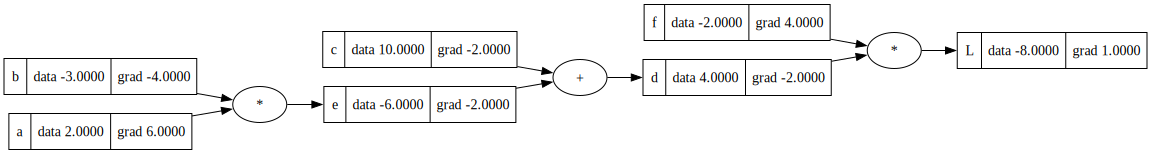

In [38]:
L.backward()
draw_dot(L)

In [95]:
class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]  # Weights
        self.b = Value(random.uniform(-1, 1))  # Bias

    def __call__(self, x):
        # Forward pass: compute the output of the neuron
        act = sum((wi * x_i for wi, x_i in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        # Return the weights and bias of the neuron
        return self.w + [self.b]
    
class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]  # Create n_out neurons

    def __call__(self, x):
        # Forward pass: compute the output of the layer
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # Return the parameters (weights and biases) of all neurons in the layer
        params = []
        for n in self.neurons:
            params.extend(n.parameters())
        return params
    
class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs  # Hidden layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]  # Output layer

    def __call__(self, x):
        # Forward pass: compute the output of the MLP
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        # Return the parameters (weights and biases) of all layers in the MLP
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

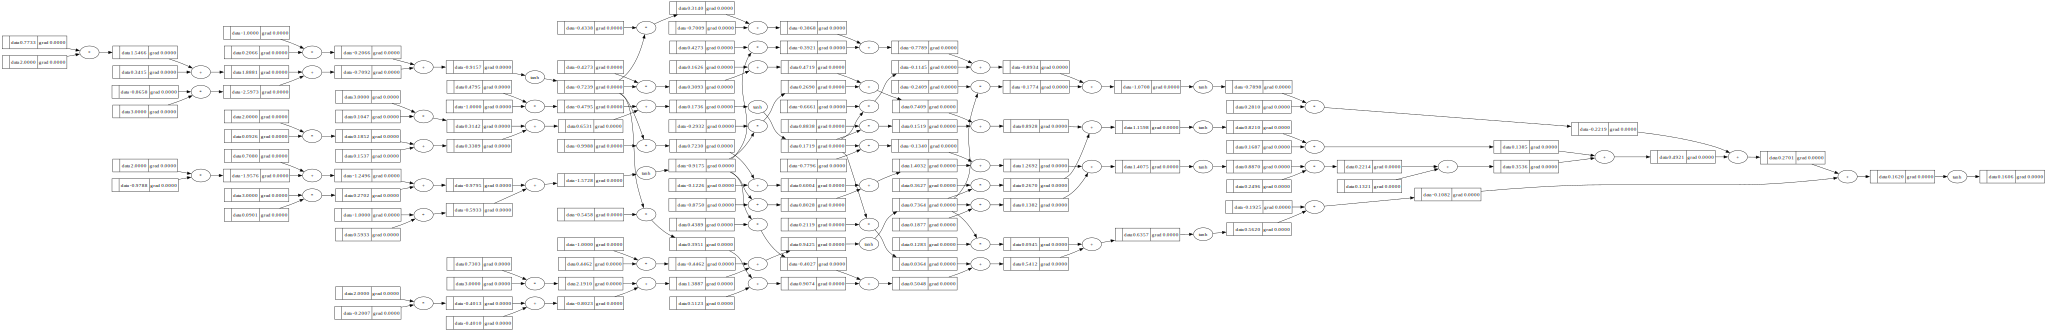

In [97]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
out = n(x)
draw_dot(out)

In [83]:
# example dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

[Value(data=-0.642359825732012),
 Value(data=-0.9008206840573746),
 Value(data=-0.9581182570367196),
 Value(data=-0.6322192757089087)]

In [121]:
n = MLP(3, [4, 4, 2, 1])

# Create training loop
for epoch in range(25):
    # Forward pass and compute predictions
    ypred = [n(x) for x in xs]

    # Compute loss (mean squared error)
    loss =  sum(((ypred[i] - ys[i]) * (ypred[i] - ys[i]) for i in range(len(xs))), Value(0.0))
    loss.backward()

    # Update parameters and reset gradients
    for p in n.parameters():
        p.data -= 0.05 * p.grad
        p.grad = 0.0

    print(f"Epoch {epoch+1}, Loss: {loss.data:.4f}")

Epoch 1, Loss: 4.1274
Epoch 2, Loss: 3.7029
Epoch 3, Loss: 3.4829
Epoch 4, Loss: 3.2875
Epoch 5, Loss: 3.0954
Epoch 6, Loss: 2.8998
Epoch 7, Loss: 2.6888
Epoch 8, Loss: 2.4391
Epoch 9, Loss: 2.1136
Epoch 10, Loss: 1.6773
Epoch 11, Loss: 1.1601
Epoch 12, Loss: 0.7100
Epoch 13, Loss: 0.4361
Epoch 14, Loss: 0.2928
Epoch 15, Loss: 0.2143
Epoch 16, Loss: 0.1668
Epoch 17, Loss: 0.1357
Epoch 18, Loss: 0.1140
Epoch 19, Loss: 0.0980
Epoch 20, Loss: 0.0858
Epoch 21, Loss: 0.0762
Epoch 22, Loss: 0.0685
Epoch 23, Loss: 0.0621
Epoch 24, Loss: 0.0568
Epoch 25, Loss: 0.0523


In [88]:
loss = sum(((ypred[i] - ys[i]) * (ypred[i] - ys[i]) for i in range(len(xs))), Value(0.0))
loss

Value(data=5.373076178278689)

In [89]:
loss.backward()

In [90]:
n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].b.grad

(-0.048945880704698796, -0.057667194882272135)

In [ ]:
for p in n.parameters():
    p.data -= 0.01 * p.grad  # Gradient descent step